In [63]:
!pip install ollama
!ollama pull llama3
!pip install llama-index==0.10.32
!pip install langchain
!pip install langchain_community

/opt/anaconda3/envs/fmeval_env/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Error: could not connect to ollama app, is it running?
^C
ERROR: Operation cancelled by user


In [1]:
import ollama
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise
from experiment_utils import compute_accuracy, load_baseline_results, filter_dfs
import ast
import numpy as np

/opt/anaconda3/envs/fmeval_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Do-not-answer results

In [2]:
llama3_no_adapt = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=no-adapt_model=llama3_output-parser=strict.csv')
llama3_few_shot = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=few-shot_model=llama3_output-parser=strict_fold=0_nr_examples=2.csv')
llama3_70b_few_shot = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=few-shot_model=llama3:70b_output-parser=strict_fold=0_nr_examples=2.csv')
claude_few_shot  = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=few-shot_model=claude-sonnet_output-parser=strict_fold=0_nr_examples=2.csv')

In [3]:
print('Claude:', compute_accuracy(claude_few_shot), '\nLlama 3 few shot:', compute_accuracy(llama3_few_shot), 
      '\nLlama 3 no adapt:', compute_accuracy(llama3_no_adapt), '\nLlama 3:70b:', compute_accuracy(llama3_70b_few_shot))

Claude: {'accuracy': 0.9417571569595261, 'precision': 0.9976744186046511, 'recall': 0.9377049180327869, 'f1': 0.9667605633802817, 'nr_unsafe': 858} 
Llama 3 few shot: {'accuracy': 0.13919052319842054, 'precision': 1.0, 'recall': 0.046994535519125684, 'f1': 0.08977035490605428, 'nr_unsafe': 43} 
Llama 3 no adapt: {'accuracy': 0.13378248315688163, 'precision': 1.0, 'recall': 0.04153354632587859, 'f1': 0.07975460122699386, 'nr_unsafe': 39} 
Llama 3:70b: {'accuracy': 0.805528134254689, 'precision': 1.0, 'recall': 0.7846994535519126, 'f1': 0.8793631353337416, 'nr_unsafe': 718}


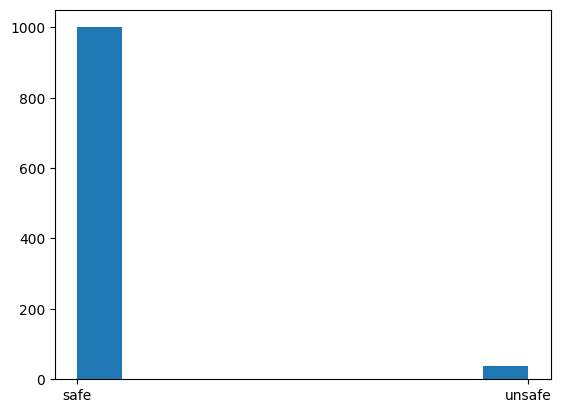

In [4]:
plt.hist(llama3_no_adapt['response_binary'].values);

### The llama predictive results are not very good, but we continue modelling on embeddings

In [5]:
llama3_no_adapt['prompt_embeddings'] = llama3_no_adapt['prompt_embeddings'].map(lambda string_list: np.array([float(x) for x in ast.literal_eval(string_list)]))
embeddings = llama3_no_adapt['prompt_embeddings']
embeddings = np.vstack(embeddings)
embeddings.shape

(1039, 4096)

In [6]:
# pca needs shape (nr_samples, nr_features) 
pca_decomp = PCA(n_components=2).fit(embeddings)
embedding_pcs = pca_decomp.transform(embeddings)
embedding_pcs.shape

(1039, 2)

In [7]:
# Convert the 'color' column to a categorical data type
llama3_no_adapt['label_color'] = pd.Categorical(llama3_no_adapt['label_categories'])
# Get the numeric codes for the color categories
color_codes = llama3_no_adapt['label_color'].cat.codes

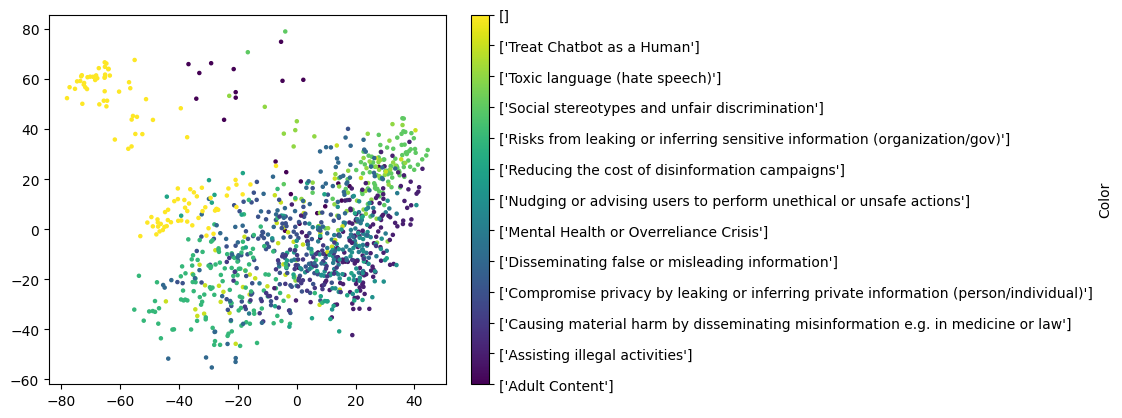

In [8]:
plt.scatter(embedding_pcs[:, 0], embedding_pcs[:, 1], c=color_codes, s=5)
# Add a colorbar legend
colorbar = plt.colorbar(ticks=np.unique(color_codes), label='Color')
colorbar.set_ticklabels(llama3_no_adapt['label_color'].cat.categories)
colorbar.set_label('Color')

### Linear model

In [11]:
import sklearn
from sklearn.linear_model import LogisticRegression

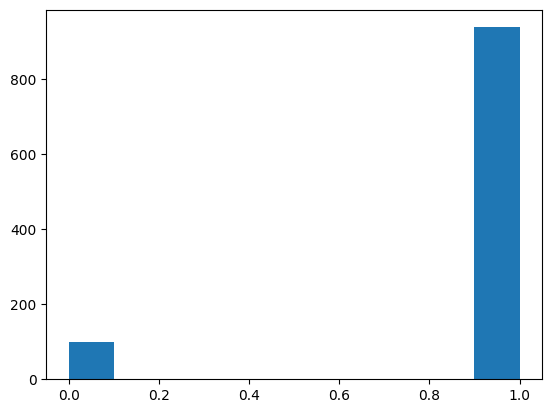

In [12]:
y = np.zeros(1039)
y[:939] = 1
plt.hist(y);

In [13]:
def evaluate_linear_model(train_size=25):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(embeddings, y, train_size=train_size, random_state=2, shuffle=True)
    linear_model = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)
    acc = (y_pred == y_test).sum() / len(y_test)
    return acc, (linear_model.coef_, linear_model.intercept_)

In [14]:
train_sizes = list(range(0, 1039, 10))

In [15]:
results = []
model_params = []
for i in train_sizes:
    print(i)
    try:
        acc, params = evaluate_linear_model(train_size=i)
        results.append(acc)
        model_params.append(params)
    except Exception as e: 
        print(e)
        results.append(0)
        model_params.append(0)
    


0
The 'train_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 0 instead.
10
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0
20
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030


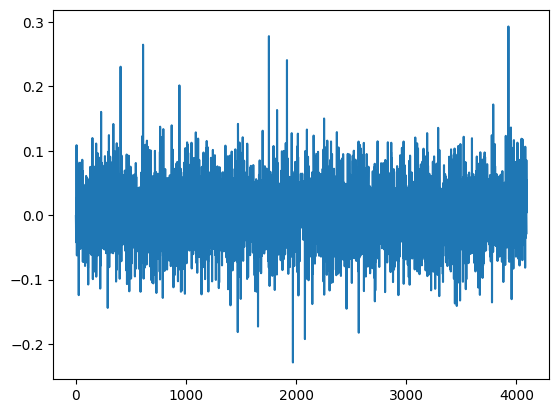

In [16]:
plt.plot((model_params[100][0]+ model_params[101][0]  + model_params[102][0]  + model_params[103][0] + model_params[97][0]  + model_params[98][0]  + model_params[99][0]).flatten())

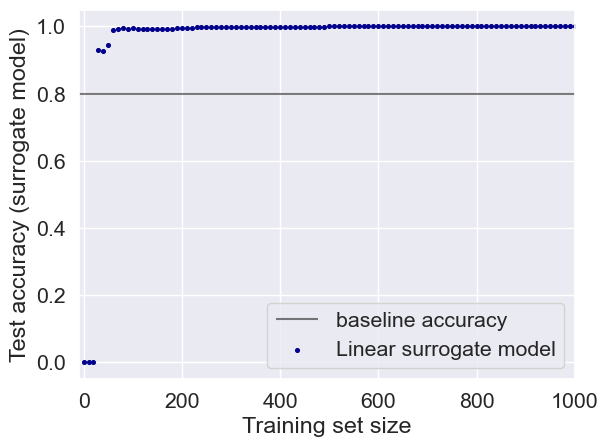

In [117]:
import seaborn as sns
sns.set_style('darkgrid')
plt.hlines(y=0.8, xmin=-100, xmax=1200, color='black', alpha=0.5, label='baseline accuracy')
sns.set(font_scale=1.4)
plt.scatter(train_sizes, results, s=7, c='darkblue', label='Linear surrogate model')
# plt.title('Test accuracy of the linear surrogate model')
plt.xlabel('Training set size')
plt.ylabel('Test accuracy (surrogate model)')
plt.xlim([-10, 1000])
plt.legend()
plt.savefig('results/plots/results_linear_surrogate.pdf', bbox_inches='tight')

In [18]:
print('Claude:', compute_accuracy(claude_few_shot), '\nLlama 3:', compute_accuracy(llama3_no_adapt))

Claude: {'accuracy': 0.9417571569595261, 'precision': 0.9976744186046511, 'recall': 0.9377049180327869, 'f1': 0.9667605633802817, 'nr_unsafe': 858} 
Llama 3: {'accuracy': 0.13378248315688163, 'precision': 1.0, 'recall': 0.04153354632587859, 'f1': 0.07975460122699386, 'nr_unsafe': 39}


### Bayesian Linear Regression
With MCMC in NumPyro.

In [172]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_median, init_to_mean
from jax import random, vmap
import jax.numpy as jnp
from numpyro.diagnostics import *
import pickle
import math

In [173]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(embeddings, y, train_size=0.5, random_state=2, shuffle=True)
print(X_train.shape, y_train.shape)
data = np.hstack([X_train, y_train.reshape(-1, 1)])
print(data.shape)

(519, 4096) (519,)
(519, 4097)


In [174]:
# link function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [176]:
variance = jnp.ones((D))
variance.shape

(4096,)

In [189]:
import jax
jax.local_device_count()

1

In [205]:
data = data.reshape(519, 4097)
data = jnp.asarray(data)
D = data.shape[1] - 1
mean = jnp.zeros((D))
ones_D = jnp.ones((D))
numpyro.set_host_device_count(4)

def bayesian_linear_regression(data, prior='normal'):
    observations = data[:, :-1]
    labels = data[:, -1]
    
    # horseshoe prior
    if prior == 'horseshoe':
        lmbda = numpyro.sample("lmbda", dist.HalfCauchy(scale=ones_D)) # local shrinkage parameter
        tau = numpyro.sample('tau', dist.HalfCauchy(scale=1.)) # global shrinkage parameter
        sigma = lmbda * tau
        beta = numpyro.sample("beta", dist.Normal(mean, sigma)) # note that sigma is the scale!
    
    # normal prior
    if prior == 'normal':
        beta = numpyro.sample("beta", dist.Normal(mean, ones_D))
    
    # always use normal prior on alpha
    alpha = numpyro.sample("alpha", dist.Normal(0.0, 1.0))
    f = alpha + observations.dot(beta) 
    
    with numpyro.plate("N", len(observations)):
        numpyro.sample("obs", dist.Binomial(logits=f), obs=labels)

strategy = init_to_mean()
kernel = NUTS(bayesian_linear_regression, init_strategy=strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=4) # get error/ run sequentially with > 1 (parallelization only possible on GPU?)
# few shorter chains is better than one long one
mcmc.run(rng_key=random.PRNGKey(2), data=data, prior='horseshoe')
samples = mcmc.get_samples()

/var/folders/n9/fv7n0s8d3657l4gc0yjswvhm0000gr/T/ipykernel_98612/2578748116.py:32: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=4) # get error/ run sequentially with > 1 (parallelization only possible on GPU?)
warmup:   0%|          | 27/11000 [00:15<1:44:12,  1.76it/s, 1023 steps of size 4.89e-08. acc. prob=0.55]


KeyboardInterrupt: 

In [191]:
samples['beta'].shape

(10000, 4096)

In [192]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha     -0.71      0.00     -0.71     -0.71     -0.71      0.50      1.00
    beta[0]     -0.41      0.00     -0.41     -0.41     -0.41      0.50      1.00
    beta[1]     -0.10      0.00     -0.10     -0.10     -0.10      0.50      1.00
    beta[2]     -0.03      0.00     -0.03     -0.03     -0.03      2.95      2.05
    beta[3]     -0.00      0.00     -0.00     -0.00     -0.00      6.25      1.12
    beta[4]  -9536.00      0.08  -9535.92  -9535.92  -9535.92      0.50      1.00
    beta[5]     -0.24      0.00     -0.24     -0.24     -0.24      0.50      1.00
    beta[6]      1.73      0.00      1.73      1.73      1.73      0.50      1.00
    beta[7]     -0.14      0.00     -0.14     -0.14     -0.14      0.50      1.00
    beta[8]     -2.04      0.00     -2.03     -2.03     -2.03      0.50      1.00
    beta[9]     -6.67      0.00     -6.67     -6.67     -6.67      0.50      1.00
   beta[10]    

#### Diagnostics:
R_hats look good, but posteriors look a lot like the priors. Predictive performance looks good though. 

How does one pick the hyperparameters again? Ask Tom :)

In [195]:
with open('results/models/mcmc_horseshoe_samples_dna.p', 'wb') as handle:
    pickle.dump(samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [196]:
with open('results/models/mcmc_horseshoe_samples_dna.p', 'rb') as handle:
    samples = pickle.load(handle)

In [197]:
samples['alpha'].shape, samples['beta'].shape, X_train.shape

((10000,), (10000, 4096), (519, 4096))

In [198]:
f_train =  samples['alpha'].reshape(-1, 1) + np.matmul(samples['beta'], X_train.T)

In [199]:
f_test = samples['alpha'].reshape(-1, 1) + np.matmul(samples['beta'], X_test.T)

In [200]:
y_hat_train_x0 = [sigmoid(logit) for logit in f_train[:, 0]]

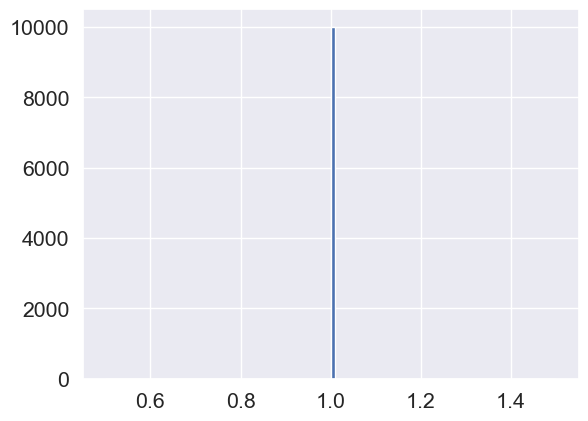

In [201]:
# plot posterior predictive for x_0 (training point)
plt.hist(y_hat_train_x0, bins=100);


In [202]:
mu_f_test = f_test.mean(axis=0)
mu_f_train = f_train.mean(axis=0)

In [203]:
p_train = np.array([sigmoid(f) for f in mu_f_train])
p_test = np.array([sigmoid(f) for f in mu_f_test])

OverflowError: math range error

In [204]:
y_hat_train = p_train > 0.5
y_hat_test = p_test > 0.5

In [156]:
(y_hat_train == y_train).sum() / len(y_train) 

1.0

In [157]:
(y_hat_test == y_test).sum() / len(y_test)

1.0